<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/KerasTransfer(ResNet50v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [1]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 5.7MB/s 


In [2]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [3]:
# # from cloud_tpu_client import Client
# # c = Client()
# # c.configure_tpu_version(tf.__version__, restart_type="always")



import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers.experimental import preprocessing
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efn
from tensorflow.keras.models import load_model

In [5]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [6]:
traindf = pd.read_csv('data/train_labels.csv',dtype=str)
testdf = pd.read_csv('data/sample.csv',dtype=str)

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
batch_size = 32
NUM_CLASSES = 80
IMG_SIZE = 224
image_size = (IMG_SIZE,IMG_SIZE)

train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="data/train_set/train_set/",
x_col="img_name",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="data/test_set/test_set/",
x_col="img_name",
y_col="label",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size)

Found 24490 validated image filenames belonging to 80 classes.
Found 6122 validated image filenames belonging to 80 classes.
Found 7653 validated image filenames.


In [7]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [8]:
def plot_hist(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

Learning rate per epoch:


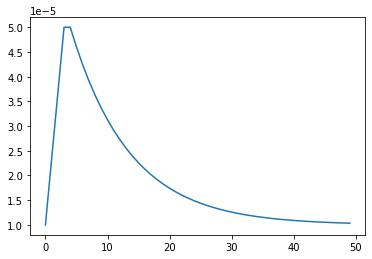

In [9]:
epochs = 50
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 
rampup_epochs = 3
sustain_epochs = 1
exp_decay = .9

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5",verbose=1,save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01,mode = 'min',
    patience=5,verbose = 0, restore_best_weights = True)
]

In [11]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    # model = efn.EfficientNetB5(include_top=False, input_tensor=x, weights='noisy-student') 
    model = ResNet50V2(include_top=False, input_tensor=x, weights="imagenet")
    # model.load_weights("efficientnet-b3_noisy-student_notop.h5")
    # model.input_tensor(x)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

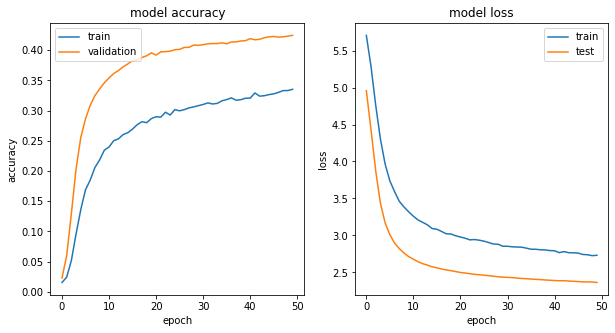

In [12]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)
# model.summary() 

hist = model.fit(train_generator, 
                 epochs=epochs,
                 validation_data=valid_generator,
                 callbacks=callbacks, 
                 verbose=1)
plot_hist(hist)

In [13]:
loss, accuracy = model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

192/192 [==============================] - 14s 75ms/step - loss: 2.3640 - accuracy: 0.4244
Validation: accuracy = 0.424371  ;  loss = 2.363994 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
766/766 [==============================] - ETA: 0s - loss: 2.6646 - accuracy: 0.3516
Epoch 00001: val_loss improved from 2.36399 to 2.26976, saving model to save_at_1.h5
766/766 [==============================] - 78s 101ms/step - loss: 2.6646 - accuracy: 0.3516 - val_loss: 2.2698 - val_accuracy: 0.4459

Epoch 00002: LearningRateScheduler reducing learning rate to 2.3333333333333336e-05.
Epoch 2/50
766/766 [==============================] - ETA: 0s - loss: 2.5825 - accuracy: 0.3683
Epoch 00002: val_loss improved from 2.26976 to 2.21968, saving model to save_at_2.h5
766/766 [==============================] - 75s 99ms/step - loss: 2.5825 - accuracy: 0.3683 - val_loss: 2.2197 - val_accuracy: 0.4548

Epoch 00003: LearningRateScheduler reducing learning rate to 3.666666666666667e-05.
Epoch 3/50
766/766 [==============================] - ETA: 0s - loss: 2.4885 - accuracy: 0.3868
Epoch 00003: val_loss improved from

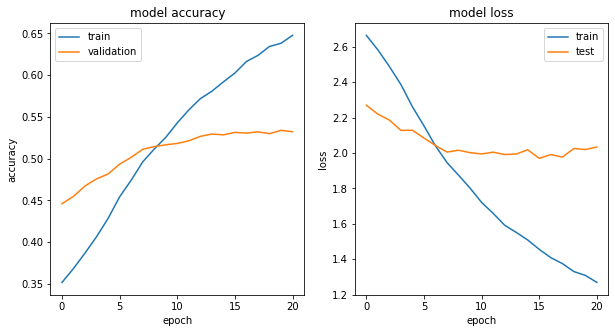

In [14]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  
hist = model.fit(train_generator, epochs=epochs, callbacks=callbacks, validation_data=valid_generator, verbose=1)
plot_hist(hist)

In [15]:
loss, accuracy = model.evaluate(valid_generator)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

192/192 [==============================] - 15s 81ms/step - loss: 1.9696 - accuracy: 0.5314
Validation: accuracy = 0.531362  ;  loss = 1.969629 


In [16]:
test_generator.reset()

pred=model.predict(test_generator,
steps=test_generator.n//test_generator.batch_size,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

7653/7653 [==============================] - 51s 7ms/step


In [18]:
model.save("final.h5")

In [17]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________________________________________________________________________